compute_spectral_normal
refer: https://github.com/sthalles/blog-resources/blob/master/sagan/libs/convolutions.py

multi_gpu
refer: https://keras.io/utils/#multi_gpu_model

plot_model

In [1]:
# Resource: https://github.com/Hhhhhhhhhhao/papers/tree/master/SAGAN

from keras import backend as K
from keras.layers import InputSpec
from keras.layers import Layer

import tensorflow as tf

from keras.datasets import mnist, cifar10
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Activation, Conv2D, UpSampling2D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import numpy as np
import os
import sys
from PIL import Image
from glob import glob

Using TensorFlow backend.


In [2]:
def check_folder(log_dir):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    return log_dir

In [3]:
class Attention(Layer):
    def __init__(self, ch, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.channels = ch
        self.filters_f_g = self.channels // 8
        self.filters_h = self.channels

    def build(self, input_shape):
        kernel_shape_f_g = (1, 1) + (self.channels, self.filters_f_g)
        print(kernel_shape_f_g)
        kernel_shape_h = (1, 1) + (self.channels, self.filters_h)

        # Create a trainable weight variable for this layer:
        self.gamma = self.add_weight(name='gamma', shape=[1], initializer='zeros', trainable=True)
        self.kernel_f = self.add_weight(shape=kernel_shape_f_g, initializer='glorot_uniform', name='kernel_f')
        self.kernel_g = self.add_weight(shape=kernel_shape_f_g, initializer='glorot_uniform', name='kernel_g')
        self.kernel_h = self.add_weight(shape=kernel_shape_h, initializer='glorot_uniform', name='kernel_h')
        self.bias_f = self.add_weight(shape=(self.filters_f_g,), initializer='zeros', name='bias_F')
        self.bias_g = self.add_weight(shape=(self.filters_f_g,), initializer='zeros', name='bias_g')
        self.bias_h = self.add_weight(shape=(self.filters_h,), initializer='zeros', name='bias_h')
        super(Attention, self).build(input_shape)
        # Set input spec.
        self.input_spec = InputSpec(ndim=4,
                                    axes={3: input_shape[-1]})
        self.built = True

    def call(self, x):
        def hw_flatten(x):
            return K.reshape(x, shape=[K.shape(x)[0], K.shape(x)[1]*K.shape(x)[2], K.shape(x)[-1]])

        f = K.conv2d(x, kernel=self.kernel_f, strides=(1, 1), padding='same')  # [bs, h, w, c']
        f = K.bias_add(f, self.bias_f)
        g = K.conv2d(x, kernel=self.kernel_g, strides=(1, 1), padding='same')  # [bs, h, w, c']
        g = K.bias_add(g, self.bias_g)
        h = K.conv2d(x, kernel=self.kernel_h, strides=(1, 1), padding='same')  # [bs, h, w, c]
        h = K.bias_add(h, self.bias_h)

        # N = h * w
        #flatten_g = hw_flatten(g)
        #flatten_f = hw_flatten(f)
        s = tf.matmul(hw_flatten(g), hw_flatten(f), transpose_b=True)  # # [bs, N, N]
        #s = K.batch_dot(flatten_g, K.transpose(flatten_f), axes=[1,2])  # # [bs, N, N]

        beta = K.softmax(s, axis=-1)  # attention map

        o = K.batch_dot(beta, hw_flatten(h))  # [bs, N, C]

        o = K.reshape(o, shape=K.shape(x))  # [bs, h, w, C]
        x = self.gamma * o + x

        return x

    def compute_output_shape(self, input_shape):
        return input_shape

In [4]:
class GAN:
    def __init__(self, dataset='MNIST'):
        self.dataset = dataset
        if dataset == 'MNIST':
            (x_train, _), (x_test, _) = mnist.load_data()
            self.x_train = []
            self.x_test = []
            for i, img in enumerate(x_train):
                img = cv2.resize(img, dsize=(32, 32))
                self.x_train.append(img)
            for i, img in enumerate(x_test):
                img = cv2.resize(img, dsize=(32, 32))
                self.x_test.append(img)
            self.x_train = np.expand_dims(self.x_train, axis=-1)
            self.x_test = np.expand_dims(self.x_test, axis=-1)
        elif dataset == 'cifar10':
            (self.x_train, _), (self.x_test, _) = cifar10.load_data()
        elif dataset == 'data_img_align_celeba':
            # img_size=(32*4,32*4), too long, unstable - behave like not enough sample, mode collapse
            # img_size=(32,32), OK! even after 1st epoch
            data_dir = './data_img_align_celeba'
            img = self.get_batch(glob(os.path.join(data_dir, '*.jpg'))[:202599], 32*4, 32*4, 'RGB') 
            train_X,valid_X = train_test_split(img, test_size=0.2, random_state=13)
            self.x_train = train_X
            self.x_test = valid_X
        elif dataset == 'data_MESSIDOR_patches':
            # try: (32*8,32*8) - see 'data_img_align_celeba' when img_size=(32*4,32*4)
            # weird generator inference output, 
            # same when data_img_align_celeba tried on 1280 data
            # Problem: not enough sample, sampling problem, mode collapse
            data_dir = './data_MESSIDOR_patches'
            img = self.get_batch(glob(os.path.join(data_dir, '*.jpg'))[:1200], 32, 32, 'RGB')  
            train_X,valid_X = train_test_split(img, test_size=0.2, random_state=13)
            self.x_train = train_X
            self.x_test = valid_X
        elif dataset == 'data_kaggle_dr':
            # OK! but after 4th epoch
            # but, need to update cropping function
            data_dir = './data_kaggle_dr/train'  # kaggle data got test also
            img = self.get_batch(glob(os.path.join(data_dir, '*.jpeg'))[:], 32, 32, 'RGB') 
            train_X,valid_X = train_test_split(img, test_size=0.2, random_state=13)
            self.x_train = train_X
            self.x_test = valid_X
        else:
            raise ValueError("dataset:{} is not valid".format(dataset))

        self.sample_dir = check_folder(dataset + '_samples/')
        self.weights_dir = check_folder(dataset + '_weights/')

        self.img_rows = self.x_train.shape[1]
        self.img_cols = self.x_train.shape[2]
        self.channels = self.x_train.shape[-1]
        self.layer_num = int(np.log2(self.img_rows)) - 3
        self.ini_size = self.img_rows // (2 ** self.layer_num)
        print(self.ini_size)
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        g_optimizer = Adam(0.0002, beta_1=0.5)
        d_optimizer = Adam(0.0004, beta_1=0.5)

        # build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=d_optimizer, metrics=['accuracy'])

        # build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generate imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # for the combined model we only train the generator
        self.discriminator.trainable = False

        # the discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # the combined model
        # train generator to fool the discriminator
        self.combined = Model(z, validity, name="generator_and_discriminator")
        self.combined.compile(loss='binary_crossentropy', optimizer=g_optimizer)
        self.combined.summary()

    def get_image(self, image_path, width, height, mode):
        image = Image.open(image_path)
        # image = image.resize([width, height], Image.BILINEAR)
        if image.size != (width, height):  
        # Remove most pixels that aren't part of a face 
            # img_width = img_height = 180
            #j = (image.size[0] - img_width) // 2
            #i = (image.size[1] - img_height) // 2
            # image = image.crop([j, i, j + img_width, i + img_height])  # (left, upper, right, lower)
            
            le = (image.size[0]*.2) 
            up = 0
            ri = (image.size[0]*.8) // 2
            lo = image.size[1]
            image = image.crop([le, up, ri, lo]) 
            image = image.resize([width, height])

        return np.array(image.convert(mode))

    def get_batch(self, image_files, width, height, mode):
        data_batch = np.array(
            [self.get_image(sample_file, width, height, mode) for sample_file in image_files])

        return data_batch    

    def build_generator(self):
        ch = 1024
        x_input = Input(shape=(self.latent_dim,))

        x = Dense(self.ini_size * self.ini_size * ch)(x_input)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Reshape((self.ini_size, self.ini_size, ch))(x)

        for i in range(self.layer_num // 2):
            x = UpSampling2D((2, 2))(x)
            x = Conv2D(ch//2, kernel_size=3, strides=1, padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            ch = ch//2

        x = Attention(ch)(x)

        for i in range(self.layer_num // 2, self.layer_num):
            x = UpSampling2D((2, 2))(x)
            x = Conv2D(ch//2, kernel_size=3, strides=1, padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            ch = ch//2

        x = Conv2D(self.channels, kernel_size=3, strides=1, padding='same')(x)
        x_output = Activation('sigmoid')(x)  # if 'sigmoid', no need rescale -1, 1, if 'tanh', yes

        model = Model(inputs=x_input, outputs=x_output, name='generator')
        model.summary()

        return model

    def build_discriminator(self):
        ch = 64
        x_input = Input(shape=self.img_shape)
        x = Conv2D(ch, kernel_size=5, strides=1, padding='same')(x_input)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

        for i in range(self.layer_num // 2):
            x = Conv2D(ch * 2, kernel_size=5, strides=2, padding='same')(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(alpha=0.2)(x)
            ch = ch * 2

        x = Attention(ch)(x)

        for i in range(self.layer_num // 2, self.layer_num):
            x = Conv2D(ch * 2, kernel_size=5, strides=2, padding='same')(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(alpha=0.2)(x)
            ch = ch * 2

        x = Conv2D(4, kernel_size=5, strides=1, padding='same')(x)
        x = Flatten()(x)
        x_output = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=x_input, outputs=x_output, name='discriminator')
        model.summary()

        return model

    def train(self, epochs, batch_size=64, label_smooth=False, sample_intervals=100):
        losses = {"g_loss":[], "d_real_loss":[], "d_fake_loss":[], "val_loss":[], "d_acc_real":[], "d_acc_fake":[], "val_real_acc":[], "val_fake_acc":[]}

        train_datagen = ImageDataGenerator(
            rotation_range=10,
            rescale=1/255.,  # if use 'tanh', rescale to -1/1
            width_shift_range=0.1,
            height_shift_range=0.1)
        val_datagen = ImageDataGenerator(rescale=1/255.)

        train_datagen.fit(self.x_train)
        val_datagen.fit(self.x_test)

        train_generator = train_datagen.flow(self.x_train, batch_size=batch_size)
        val_generator = val_datagen.flow(self.x_test, batch_size=batch_size)

        self.sample_images(0)
        for epoch in range(epochs):
            d_acc = {"real":[], "fake":[]}
            print('-' * 15, 'Epoch %d of %d' % (epoch+1, epochs), '-' * 15)
            for t in range(len(train_generator)):
                # generate batch data
                imgs = train_generator[t]  # get batch no. t

                # ----------------------
                #  Train Discriminator
                # ----------------------
                self.discriminator.trainable = True

                # Adversial ground truths
                if label_smooth:
                    valid = np.ones((imgs.shape[0], 1)) * 0.9
                else:
                    valid = np.ones((imgs.shape[0], 1))

                fake = np.zeros((imgs.shape[0], 1))

                noise = np.random.normal(0, 1, (imgs.shape[0], self.latent_dim))

                # generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # train the discriminator
                d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                losses["d_real_loss"].append(d_loss_real[0])
                losses["d_fake_loss"].append(d_loss_fake[0])
                d_acc["real"].append(100 * d_loss_real[1])
                d_acc["fake"].append(100 * d_loss_fake[1])

                # ----------------------
                #  Train Generator
                # ----------------------
                self.discriminator.trainable = False
                noise = np.random.normal(0, 1, (imgs.shape[0], self.latent_dim))
                valid = np.ones((imgs.shape[0], 1))
                # train the generator (to have the discriminator label samples as valid)
                g_loss = self.combined.train_on_batch(noise, valid)
                losses["g_loss"].append(g_loss)
                # Plot the progress
                if t%sample_intervals ==0 or t == len(train_generator)-1:
                    print("iteration:%d [D real loss: %.5a, fake loss: %.5a, real acc.: %.2f%%, fake acc.: %.2f%%] [G "
                          "loss: %g] "
                        % (t, d_loss_real[0], d_loss_fake[0], np.mean(d_acc["real"]), np.mean(d_acc["fake"]), g_loss))
                    losses["d_acc_real"].append(np.mean(d_acc["real"]))
                    losses["d_acc_fake"].append(np.mean(d_acc["fake"]))

            val_losses = {"g_loss":[], "d_loss_real":[], "d_loss_fake":[], "d_acc_real":[], "d_acc_fake":[]}
            for t in range(len(val_generator)):
                imgs = val_generator[t]
                noise = np.random.normal(0, 1, (imgs.shape[0], self.latent_dim))
                gen_imgs = self.generator.predict(noise)
                valid = np.ones((imgs.shape[0], 1))
                fake = np.zeros((imgs.shape[0], 1))
                d_loss_real = self.discriminator.test_on_batch(imgs, valid)
                d_loss_fake = self.discriminator.test_on_batch(gen_imgs, fake)
                g_loss = self.combined.test_on_batch(noise, valid)
                #d_loss = 0.5 * np.add(d_loss_fake[0], d_loss_real[0])
                val_losses["d_loss_real"].append(d_loss_real[0])
                val_losses["d_loss_fake"].append(d_loss_fake[0])
                val_losses["d_acc_real"].append(d_loss_real[1] * 100)
                val_losses["d_acc_fake"].append(d_loss_fake[1] * 100)
                val_losses["g_loss"].append(g_loss)
            losses["val_loss"].append(np.mean(val_losses["g_loss"]))
            losses["val_real_acc"].append(np.mean(val_losses["d_acc_real"]))
            losses["val_fake_acc"].append(np.mean(val_losses["d_acc_fake"]))
            # Plot the progress
            print("validation [D real loss: %.5a, fake loss: %.5a, real acc.: %.2f%%, fake acc.:%.2f%%] [G loss: %g] "
                  % (np.mean(val_losses["d_loss_real"]), np.mean(val_losses["d_loss_real"]), 
                     np.mean(val_losses["d_acc_real"]), np.mean(val_losses["d_acc_fake"]), 
                     np.mean(val_losses["g_loss"])))
            # save generated samples at epoch end
            self.sample_images(epoch+1)

        self.generator.save_weights(filepath=self.weights_dir + "generator.hdf5")
        self.discriminator.save_weights(filepath=self.weights_dir + "discriminator.hdf5")

        return losses

    def sample_images(self, epoch):
        r, c = 5, 5
        np.random.seed(1)
        noise = np.random.normal(0, 1, (r*c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        fig, axs = plt.subplots(r, c)
        count = 0

        if self.dataset == 'MNIST':
            for i in range(r):
                for j in range(c):
                    axs[i, j].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[i, j].axis('off')
                    count += 1
                fig.savefig(self.sample_dir + "/%d.png" % epoch)
                plt.close()
        else:
            for i in range(r):
                for j in range(c):
                    img = gen_imgs[count] * 255
                    img = img.astype(np.uint8)
                    axs[i, j].imshow(img)
                    axs[i, j].axis('off')
                    count += 1
                fig.savefig(self.sample_dir + "/%d.png" % epoch)
                plt.close()

In [5]:
# if __name__ == '__main__':
# {'data_img_align_celeba','MNIST',  'data_kaggle_dr', 'data_MESSIDOR_patches', 'cifar10'}
dataset = 'data_kaggle_dr'
gan = GAN(dataset)
loss_dir = check_folder(dataset + '_losses/')

8
(1, 1, 128, 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0  

In [6]:
# epochs=30
# batch_size=64
losses = gan.train(epochs=30, batch_size=64, label_smooth=False, sample_intervals=50)  

--------------- Epoch 1 of 30 ---------------
iteration:0 [D real loss: 1.096, fake loss: 11.58, real acc.: 28.12%, fake acc.: 0.00%] [G loss: 0.906279] 
iteration:50 [D real loss: 0.032, fake loss: 2.045, real acc.: 91.67%, fake acc.: 89.92%] [G loss: 0.461459] 
iteration:100 [D real loss: 0.003, fake loss: 0.064, real acc.: 94.82%, fake acc.: 94.85%] [G loss: 0.00648952] 
iteration:150 [D real loss: 0.002, fake loss: 0.002, real acc.: 95.72%, fake acc.: 95.38%] [G loss: 0.00767868] 
iteration:200 [D real loss: 0.001, fake loss: 0.003, real acc.: 96.78%, fake acc.: 96.53%] [G loss: 0.0112041] 
iteration:250 [D real loss: 0.023, fake loss: 0.001, real acc.: 96.45%, fake acc.: 96.47%] [G loss: 0.0170932] 
iteration:300 [D real loss: 0.018, fake loss: 0.014, real acc.: 97.00%, fake acc.: 97.04%] [G loss: 0.0103915] 
iteration:350 [D real loss: 0.005, fake loss: 0.010, real acc.: 97.22%, fake acc.: 97.21%] [G loss: 0.00955168] 
iteration:400 [D real loss: 0.005, fake loss: 0.001, real acc

iteration:250 [D real loss: 0.000, fake loss: 0.003, real acc.: 97.62%, fake acc.: 97.29%] [G loss: 0.00909513] 
iteration:300 [D real loss: 0.011, fake loss: 0.003, real acc.: 98.01%, fake acc.: 97.73%] [G loss: 0.01845] 
iteration:350 [D real loss: 0.004, fake loss: 0.001, real acc.: 97.89%, fake acc.: 97.74%] [G loss: 0.0144637] 
iteration:400 [D real loss: 0.002, fake loss: 0.001, real acc.: 98.15%, fake acc.: 98.02%] [G loss: 0.000664363] 
iteration:439 [D real loss: 2.387, fake loss: 2.016, real acc.: 98.31%, fake acc.: 98.19%] [G loss: 2.63755e-05] 
validation [D real loss: 0.329, fake loss: 0.329, real acc.: 87.82%, fake acc.:73.80%] [G loss: 1.60365] 
--------------- Epoch 8 of 30 ---------------
iteration:0 [D real loss: 0.001, fake loss: 0.000, real acc.: 100.00%, fake acc.: 100.00%] [G loss: 0.00699016] 
iteration:50 [D real loss: 0.016, fake loss: 0.000, real acc.: 95.74%, fake acc.: 96.88%] [G loss: 0.0416744] 
iteration:100 [D real loss: 0.006, fake loss: 0.012, real acc

--------------- Epoch 14 of 30 ---------------
iteration:0 [D real loss: 0.077, fake loss: 0.169, real acc.: 100.00%, fake acc.: 98.44%] [G loss: 1.51865] 
iteration:50 [D real loss: 0.000, fake loss: 0.240, real acc.: 97.89%, fake acc.: 97.70%] [G loss: 0.196826] 
iteration:100 [D real loss: 0.069, fake loss: 0.018, real acc.: 94.88%, fake acc.: 94.86%] [G loss: 1.06429] 
iteration:150 [D real loss: 0.005, fake loss: 0.000, real acc.: 94.56%, fake acc.: 94.93%] [G loss: 0.0649125] 
iteration:200 [D real loss: 0.000, fake loss: 0.043, real acc.: 95.69%, fake acc.: 96.11%] [G loss: 0.225336] 
iteration:250 [D real loss: 0.006, fake loss: 0.005, real acc.: 95.29%, fake acc.: 95.65%] [G loss: 0.184086] 
iteration:300 [D real loss: 0.001, fake loss: 0.009, real acc.: 96.07%, fake acc.: 96.37%] [G loss: 0.0253211] 
iteration:350 [D real loss: 0.050, fake loss: 0.008, real acc.: 96.36%, fake acc.: 96.53%] [G loss: 0.184426] 
iteration:400 [D real loss: 0.029, fake loss: 0.026, real acc.: 96.

iteration:300 [D real loss: 0.727, fake loss: 1.128, real acc.: 88.81%, fake acc.: 88.70%] [G loss: 2.27833] 
iteration:350 [D real loss: 0.118, fake loss: 0.324, real acc.: 89.25%, fake acc.: 89.16%] [G loss: 4.45346] 
iteration:400 [D real loss: 2.254, fake loss: 0.357, real acc.: 89.02%, fake acc.: 89.04%] [G loss: 3.22626] 
iteration:439 [D real loss: 0.006, fake loss: 0.047, real acc.: 89.37%, fake acc.: 89.31%] [G loss: 0.068151] 
validation [D real loss: 0.391, fake loss: 0.391, real acc.: 83.10%, fake acc.:84.14%] [G loss: 2.01683] 
--------------- Epoch 21 of 30 ---------------
iteration:0 [D real loss: 0.022, fake loss: 0.169, real acc.: 100.00%, fake acc.: 93.75%] [G loss: 0.855313] 
iteration:50 [D real loss: 0.057, fake loss: 0.037, real acc.: 90.84%, fake acc.: 91.08%] [G loss: 3.79568] 
iteration:100 [D real loss: 0.100, fake loss: 0.016, real acc.: 91.83%, fake acc.: 91.82%] [G loss: 1.19475] 
iteration:150 [D real loss: 0.084, fake loss: 0.324, real acc.: 92.67%, fake 

iteration:50 [D real loss: 0.015, fake loss: 0.083, real acc.: 90.50%, fake acc.: 90.84%] [G loss: 3.03479] 
iteration:100 [D real loss: 0.017, fake loss: 0.000, real acc.: 93.02%, fake acc.: 92.81%] [G loss: 3.35385] 
iteration:150 [D real loss: 0.030, fake loss: 0.009, real acc.: 94.28%, fake acc.: 93.80%] [G loss: 0.91003] 
iteration:200 [D real loss: 0.056, fake loss: 0.543, real acc.: 93.38%, fake acc.: 92.93%] [G loss: 6.46636] 
iteration:250 [D real loss: 0.001, fake loss: 0.326, real acc.: 93.53%, fake acc.: 93.02%] [G loss: 3.01518] 
iteration:300 [D real loss: 0.028, fake loss: 0.001, real acc.: 94.25%, fake acc.: 93.85%] [G loss: 2.93408] 
iteration:350 [D real loss: 0.028, fake loss: 0.029, real acc.: 94.75%, fake acc.: 94.45%] [G loss: 3.25051] 
iteration:400 [D real loss: 0.100, fake loss: 0.001, real acc.: 95.29%, fake acc.: 95.03%] [G loss: 2.13724] 
iteration:439 [D real loss: 0.012, fake loss: 0.002, real acc.: 94.50%, fake acc.: 94.24%] [G loss: 0.0555605] 
validatio

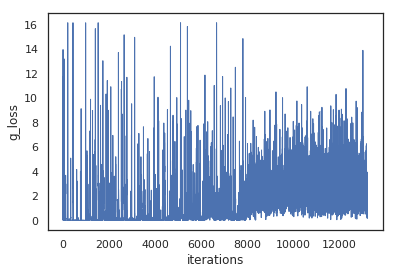

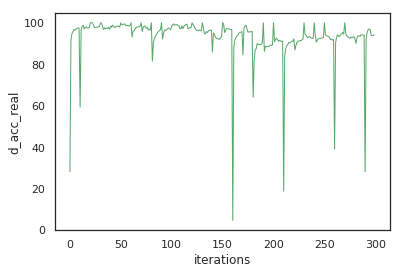

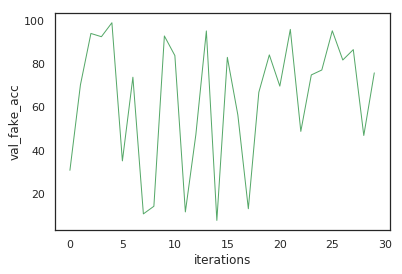

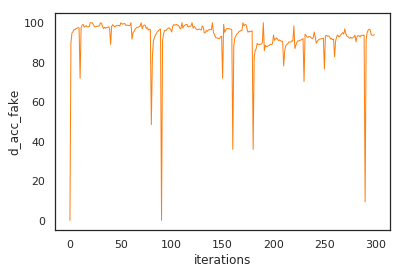

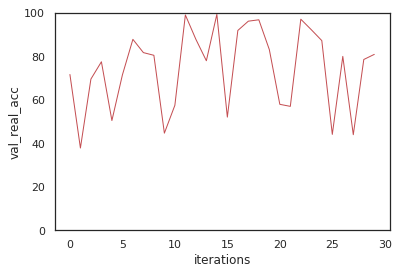

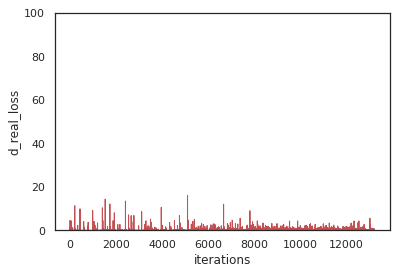

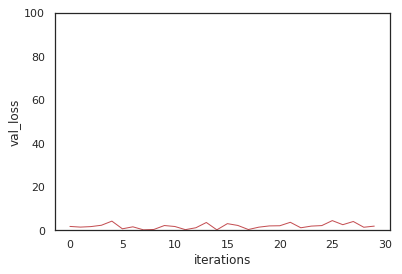

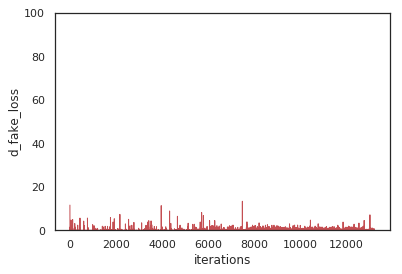

In [7]:
color = ['b', 'g', 'g', 'tab:orange', 'r', 'r', 'r', 'r']
sns.set(color_codes=True)
sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 1})

for i, key in enumerate(losses.keys()):
    if i <= 3:
        plt.plot(losses[key], color[i])
        plt.xlabel('iterations')
        plt.ylabel(key)#'loss')
        plt.savefig(loss_dir + key + ".png")
        plt.show()
        plt.close()
    else:
        plt.plot(losses[key], color[i])
        plt.ylim((0,100))
        plt.xlabel('iterations')
        plt.ylabel(key)#'accuracy')
        plt.savefig(loss_dir + key + ".png")
        plt.show()
        plt.close()